In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
url = "https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/data_loader/PeMS-M.zip"
data_dir = keras.utils.get_file(origin=url, extract=True, archive_format="zip")
data_dir = data_dir.rstrip(".zip")

route_distances = pd.read_csv(
    os.path.join(data_dir, "W_228.csv"), header=None
).to_numpy()
speeds_array = pd.read_csv(os.path.join(data_dir, "V_228.csv"), header=None).to_numpy()

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

6144000/6129354 [==============================] - 2s 0us/step
route_distances shape=(228, 228)
speeds_array shape=(12672, 228)


In [14]:
route_distances

array([[    0.  ,  3165.94,  7757.18,  2213.47,  5887.74,  4269.59,
         5371.21,  6580.34,  5271.73,  9165.09,  3153.95,  9382.32,
         4174.07,  2299.75,  7579.48,  6865.97,  3597.36,  1523.97,
         6494.29,  2908.21,  5574.54,  6485.92,  5571.97,  4665.37,
         4955.01,  6464.18],
       [ 3165.94,     0.  ,  4695.51,  1037.65,  2910.29,  1330.37,
         2391.12,  8905.88,  7658.29, 11436.41,  4646.63, 11646.7 ,
         6290.6 ,  3816.96,  9884.73,  9176.75,  1800.89,  1781.42,
         4541.54,  1270.64,  3736.09,  4525.64,  3745.69,  3184.35,
         2099.92,  8090.27],
       [ 7757.18,  4695.51,     0.  ,  5733.14,  1889.16,  3487.65,
         2391.72, 13478.02, 12273.06, 15943.74,  9145.72, 16147.63,
        10866.66,  8409.3 , 14431.76, 13738.55,  4497.44,  6474.32,
         3708.01,  4953.96,  3889.46,  3690.  ,  3910.8 ,  4494.9 ,
         2845.22, 12385.08],
       [ 2213.47,  1037.65,  5733.14,     0.  ,  3937.82,  2329.5 ,
         3416.16,  7913.43,  

In [15]:
speeds_array

array([[71.1, 66. , 67.1, ..., 69.6, 67.7, 72.3],
       [68.1, 66.8, 64.5, ..., 68.8, 68.2, 71.1],
       [68. , 64.3, 68.1, ..., 69.1, 69.2, 71. ],
       ...,
       [68.9, 37.9, 69.4, ..., 66.7, 66.7, 71.7],
       [69.2, 37.8, 68.5, ..., 66.8, 64.2, 71.7],
       [68.6, 52.9, 69.3, ..., 66.8, 65.6, 71.8]])

In [4]:
sample_routes = [
    0,
    1,
    4,
    7,
    8,
    11,
    15,
    108,
    109,
    114,
    115,
    118,
    120,
    123,
    124,
    126,
    127,
    129,
    130,
    132,
    133,
    136,
    139,
    144,
    147,
    216,
]
route_distances = route_distances[np.ix_(sample_routes, sample_routes)]
speeds_array = speeds_array[:, sample_routes]

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(26, 26)
speeds_array shape=(12672, 26)


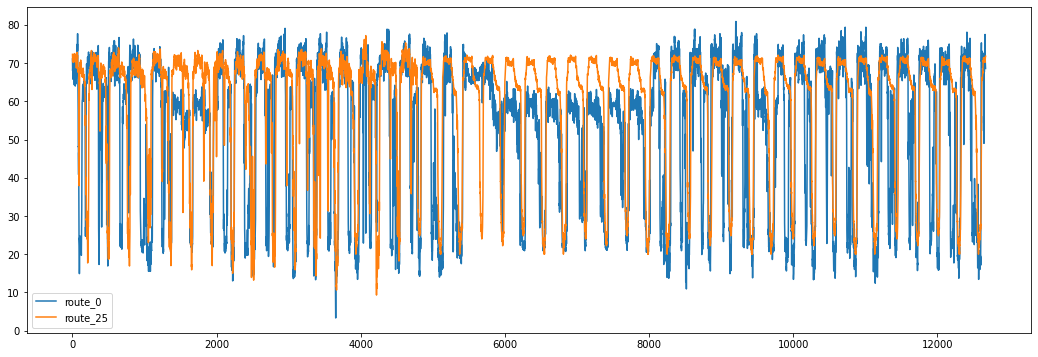

In [5]:
plt.figure(figsize=(18, 6))
plt.plot(speeds_array[:, [0, -1]])
plt.legend(["route_0", "route_25"])

Text(0, 0.5, 'road number')

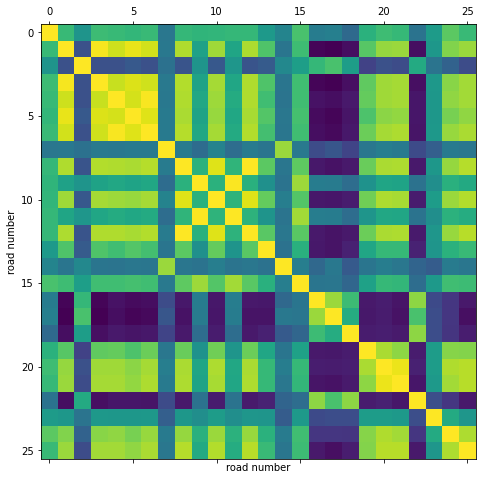

In [6]:
plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(speeds_array.T), 0)
plt.xlabel("road number")
plt.ylabel("road number")

In [7]:
train_size, val_size = 0.5, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (6336, 26)
validation set size: (2534, 26)
test set size: (3802, 26)


In [8]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

In [9]:
def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

In [10]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 26, number of edges: 150


In [11]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

In [12]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)


In [13]:
in_feat = 1
batch_size = 64
epochs = 20
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

TypeError: in user code:

    C:\Users\SEHWAN~1\AppData\Local\Temp/ipykernel_32200/544988992.py:57 call  *
        lstm_out = self.lstm(
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\layers\recurrent.py:659 __call__  **
        return super(RNN, self).__call__(inputs, **kwargs)
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py:1030 __call__
        self._maybe_build(inputs)
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py:2659 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\layers\recurrent.py:577 build
        self.cell.build(step_input_shape)
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\tf_utils.py:259 wrapper
        output_shape = fn(instance, input_shape)
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\layers\recurrent.py:2354 build
        self.kernel = self.add_weight(
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py:647 add_weight
        variable = self._add_variable_with_custom_getter(
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\training\tracking\base.py:813 _add_variable_with_custom_getter
        new_variable = getter(
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer_utils.py:117 make_variable
        return tf.compat.v1.Variable(
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\variables.py:266 __call__
        return cls._variable_v1_call(*args, **kwargs)
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\variables.py:212 _variable_v1_call
        return previous_getter(
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\variables.py:205 <lambda>
        previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\variable_scope.py:2612 default_variable_creator
        return resource_variable_ops.ResourceVariable(
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\variables.py:270 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1602 __init__
        self._init_from_args(
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1740 _init_from_args
        initial_value = initial_value()
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\initializers\initializers_v2.py:499 __call__
        fan_in, fan_out = _compute_fans(shape)
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\initializers\initializers_v2.py:1009 _compute_fans
        return int(fan_in), int(fan_out)

    TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'
